# Sparse Sensor Placement Optimization for Classification (SSPOC)

In this set of examples we show how `SSPOC` can be used to optimize sensor placement for *classification* tasks. See the following paper for the mathematical details behind the SSPOC method ([link](https://epubs.siam.org/doi/pdf/10.1137/15M1036713)):

    Brunton, Bingni W., et al. "Sparse sensor placement optimization for classification." SIAM Journal on Applied Mathematics 76.5 (2016): 2099-2122.

We'll study the problem of classifying $8\times 8$ images of handwritten digits from the [digits dataset](https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits). SSPOC approaches binary (two classes) and multiclass (more than two classes) classification problems slightly differently, so we will study both cases.

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
from sklearn import metrics
from sklearn.model_selection import train_test_split

import pysensors as ps
from pysensors.classification import SSPOC

In [2]:
# Set seed for reproducibility
random_state = 0

## Binary classification
First we'll try to classify 0's and 1's. We'll use SSPOC with a [linear discriminant analysis](https://en.wikipedia.org/wiki/Linear_discriminant_analysis) (LDA) classifier, mimicking Brunton et al.

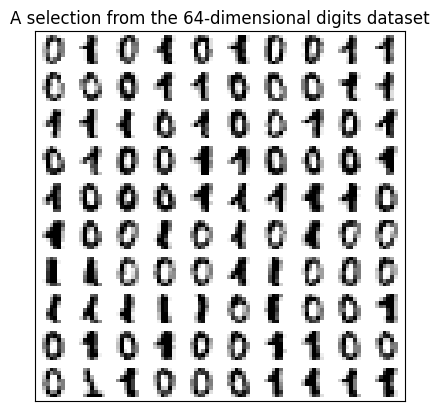

Number of examples: 360


In [3]:
# Load the data
digits = datasets.load_digits(n_class=2)
X = digits.data
y = digits.target

n_samples, n_features = X.shape

# Plot some digits
n_img_per_row = 10
img = np.zeros((10 * n_img_per_row, 10 * n_img_per_row))
for i in range(n_img_per_row):
    ix = 10 * i + 1
    for j in range(n_img_per_row):
        iy = 10 * j + 1
        img[ix:ix + 8, iy:iy + 8] = X[i * n_img_per_row + j].reshape((8, 8))

plt.imshow(img, cmap=plt.cm.binary)
plt.xticks([])
plt.yticks([])
plt.title('A selection from the 64-dimensional digits dataset')
plt.show()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=random_state)
print('Number of examples:', n_samples)

To train a `SSPOC` object to classify digits, we run the following lines.

In [4]:
model = SSPOC()
model.fit(X_train, y_train, quiet=True);

Associated with each sensor location (pixel) is a coefficient that can roughly be thought of as giving the importance of the sensor.

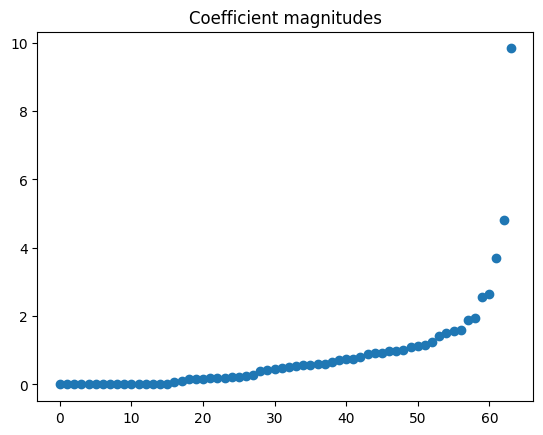

In [5]:
plt.plot(np.sort(np.abs(model.sensor_coef_)), 'o')
plt.title('Coefficient magnitudes');

We can isolate the most important sensors by ignoring sensors with coefficients below some given threshold.

In [6]:
model.update_sensors(threshold=2, xy=(X_train, y_train))
print('Portion of sensors used:', len(model.selected_sensors) / 64)
print('Selected sensors:', model.selected_sensors)

Portion of sensors used: 0.078125
Selected sensors: [ 1  6 14 28 57]


In [7]:
y_pred = model.predict(X_test[:, model.selected_sensors])
print('Incorrect classifications:', sum(np.abs(y_test - y_pred)), 'out of', len(y_test))
print('Accuracy:', metrics.accuracy_score(y_test, y_pred))

Incorrect classifications: 3 out of 90
Accuracy: 0.9666666666666667


LDA attains a high accuracy using only a small number of sensors! Let's see which sensors were used.

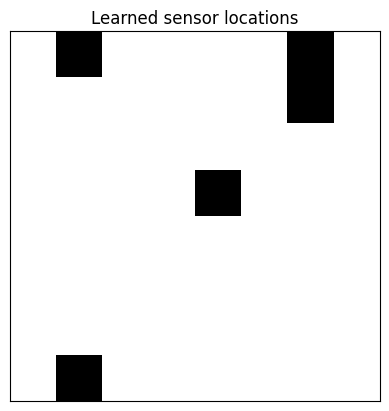

In [8]:
# Plot sensor locations
def plot_sensor_locations(sensors, ax=None):
    img = np.zeros(64)
    img[sensors] = 16
    
    if ax is None:
        plt.imshow(img.reshape(8, 8), cmap=plt.cm.binary)
        plt.xticks([])
        plt.yticks([])
        plt.title('Learned sensor locations')
    else:
        ax.imshow(img.reshape(8, 8), cmap=plt.cm.binary)
        ax.set(xticks=[], yticks=[], title='Learned sensor locations')
        

plot_sensor_locations(model.selected_sensors)

We can also directly select the number of sensors we'd like the classifier to use. Let's check how the accuracy of the model changes as we vary the number of sensors.

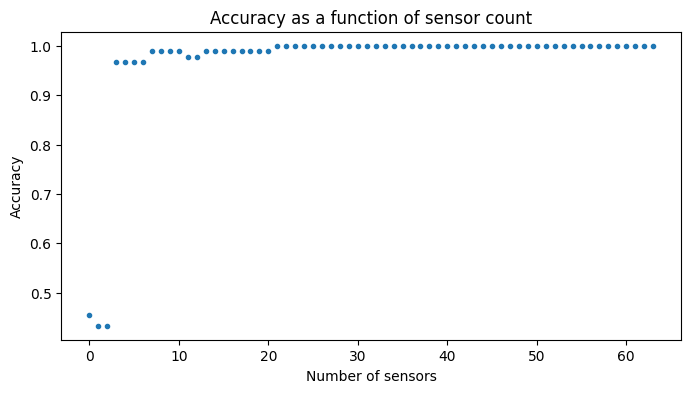

In [9]:
n_sensors_array = np.arange(64)
accuracy = np.zeros(64)

# Suppress warnings arising from no sensors being selected
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning)

    for n_sensors in n_sensors_array:
        model.update_sensors(n_sensors=n_sensors, xy = (X_train, y_train), quiet=True)
        if n_sensors == 0:
            accuracy[n_sensors] = metrics.accuracy_score(y_test, model.predict(X_test))
        else:
            accuracy[n_sensors] = metrics.accuracy_score(y_test, model.predict(X_test[:, model.selected_sensors]))

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(n_sensors_array, accuracy, '.')
ax.set(xlabel="Number of sensors", ylabel="Accuracy", title="Accuracy as a function of sensor count");

## Multiclass classification
Next we'll look at a multiclass classification problem: classifying the digits 0-9. We'll stick with LDA as our classifier.

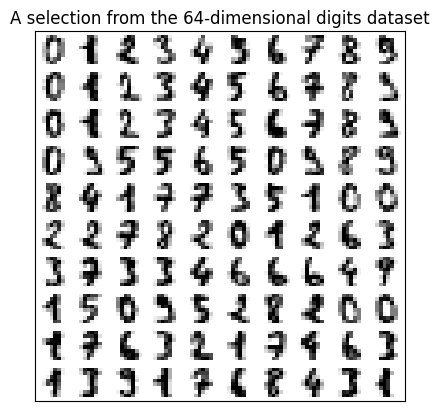

Number of samples: 1797


In [10]:
# Load data
digits = datasets.load_digits(n_class=10)
X = digits.data
y = digits.target

n_samples, n_features = X.shape

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=random_state)

# Plot some digits
n_img_per_row = 10
img = np.zeros((10 * n_img_per_row, 10 * n_img_per_row))
for i in range(n_img_per_row):
    ix = 10 * i + 1
    for j in range(n_img_per_row):
        iy = 10 * j + 1
        img[ix:ix + 8, iy:iy + 8] = X[i * n_img_per_row + j].reshape((8, 8))

plt.imshow(img, cmap=plt.cm.binary)
plt.xticks([])
plt.yticks([])
plt.title('A selection from the 64-dimensional digits dataset')
plt.show()

print('Number of samples:', n_samples)

The fitting process is similar to the binary classification case, but there is an extra parameter that comes into play, `l1_penalty`. We'll explore different choices of `l1_penalty` in a later section. Note that we can also pre-specify a threshold to avoid having to call `update_sensors`.

In [11]:
threshold = 0.1
l1_penalty = 0.01
model = SSPOC(threshold=threshold, l1_penalty=l1_penalty)
model.fit(X_train, y_train, random_state=random_state)

print('Portion of sensors used:', len(model.selected_sensors) / 64)
print('Selected sensors:', model.selected_sensors)

Portion of sensors used: 0.578125
Selected sensors: [ 1  3  5  6  7  8 10 12 15 16 20 21 22 23 24 30 31 33 38 40 41 42 43 44
 45 46 47 48 49 52 53 55 56 57 60 62 63]


In [12]:
# Check accuracy on training set
y_pred = model.predict(X_test[:, model.selected_sensors])
print('Accuracy:', metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9044444444444445


Although the classifier used more sensors, its accuracy is lower than it was for the binary classification problem. Multiclass classification problems tend to be inherently harder than binary ones.

Let's see which sensors the model selected.

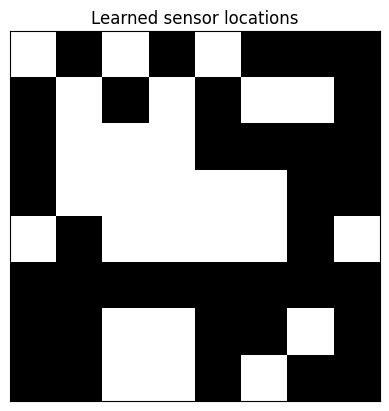

In [13]:
plot_sensor_locations(model.selected_sensors)

We can also get a better idea of which digits (classes) give the classifier the most trouble.

Classification report for classifier SSPOC(basis=Identity(n_basis_modes=1347),
      classifier=LinearDiscriminantAnalysis(), l1_penalty=0.01, n_sensors=37,
      threshold=0.1):
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        37
           1       0.82      0.86      0.84        43
           2       0.90      0.82      0.86        44
           3       0.75      0.87      0.80        45
           4       0.95      0.97      0.96        38
           5       1.00      0.92      0.96        48
           6       1.00      1.00      1.00        52
           7       0.92      0.96      0.94        48
           8       0.91      0.85      0.88        48
           9       0.86      0.81      0.84        47

    accuracy                           0.90       450
   macro avg       0.91      0.91      0.90       450
weighted avg       0.91      0.90      0.90       450




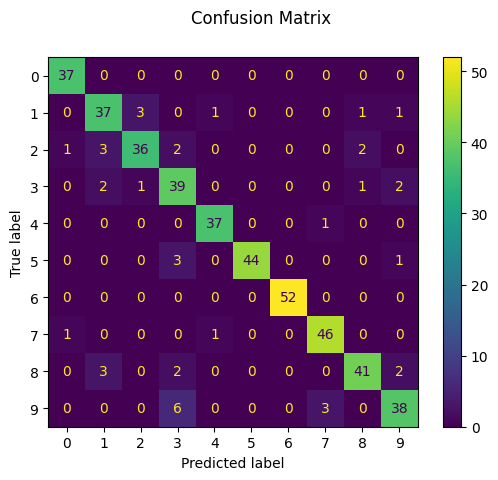

In [14]:
print("Classification report for classifier %s:\n%s\n"
      % (model, metrics.classification_report(y_test, y_pred)))
disp = metrics.ConfusionMatrixDisplay.from_estimator(model.classifier, X_test[:, model.selected_sensors], y_test)
disp.figure_.suptitle("Confusion Matrix")

plt.show()

The model seems to have the most difficulty with 3's.

### Choosing sensors
For multiclass problems the "importance coefficients" form a matrix, with each row corresponding to a pixel and each column to a class. In order to select important sensors (pixels/rows), a function is applied row-wise to aggregate coefficients into a sigle score for each sensor, forming a vector of scores. These scores are then used to choose which sensors to retain. Note that if `l1_penalty` was set too high, then the importance coefficients matrix may not have any nonzero entries, making it impossible to prioritize which sensors to select.

Below we give examples of some possible aggregating functions.

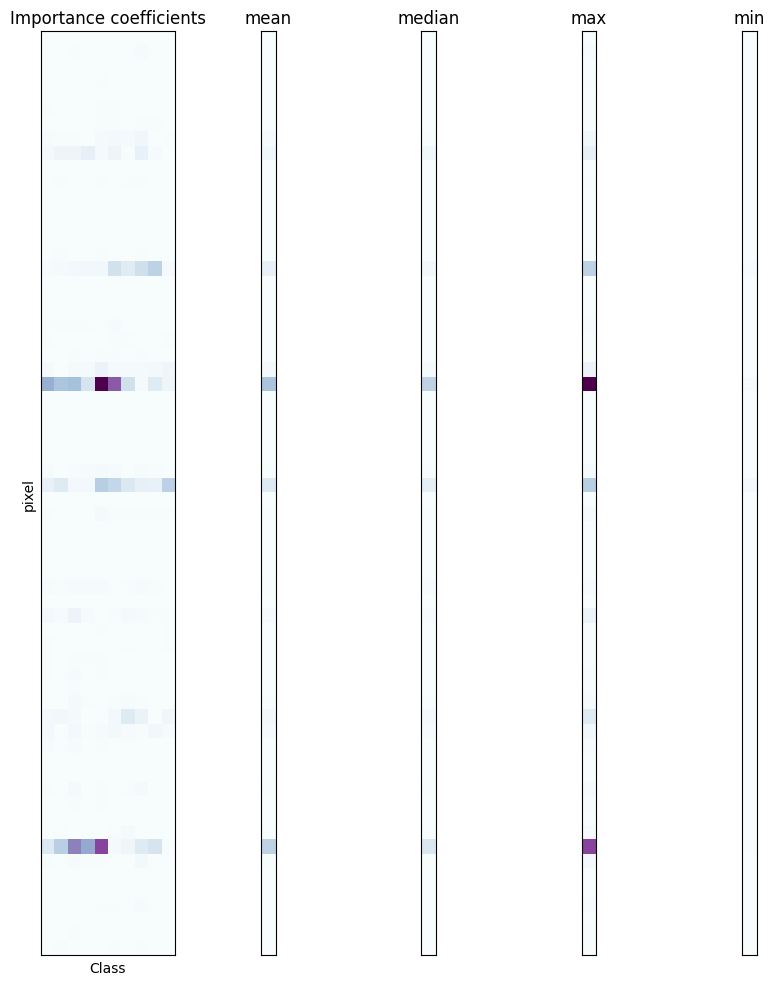

In [15]:
methods = [
    ('mean', np.mean),
    ('median', np.median),
    ('max', np.max),
    ('min', np.min)
]

# Normalize the colormaps
coef_magnitudes = np.abs(model.sensor_coef_)
vmin = np.min(coef_magnitudes)
vmax = np.max(coef_magnitudes)

plot_kws = dict(vmin=vmin, vmax=vmax, cmap="BuPu")

fig, axs = plt.subplots(1, len(methods) + 1, sharey=True, figsize=(10, 12))

axs[0].matshow(coef_magnitudes, aspect="auto", **plot_kws)
axs[0].set(xlabel="Class", ylabel="pixel", title="Importance coefficients", xticks=[], yticks=[])

for k, (name, method) in enumerate(methods, 1):
    axs[k].matshow(method(coef_magnitudes, axis=1).reshape(-1, 1), **plot_kws)
    axs[k].set(title=name, xticks=[], yticks=[])

Once we have this score vector, there are a two ways we might use it to select sensors:
1. Take the sensors corresponding to the **top-k** scores
2. Take *all* sensors with scores exceeding some **threshold**

We explore both options below. Note that, for simplicity, we measure accuracy on the training set. Generally one should create a holdout/test set to obtain an unbiased estimate of the accuracy.

#### Top-k sensors
Here we measure how the performance of the classifier changes as we directly vary the number of sensors for four different choices of aggregating methods.

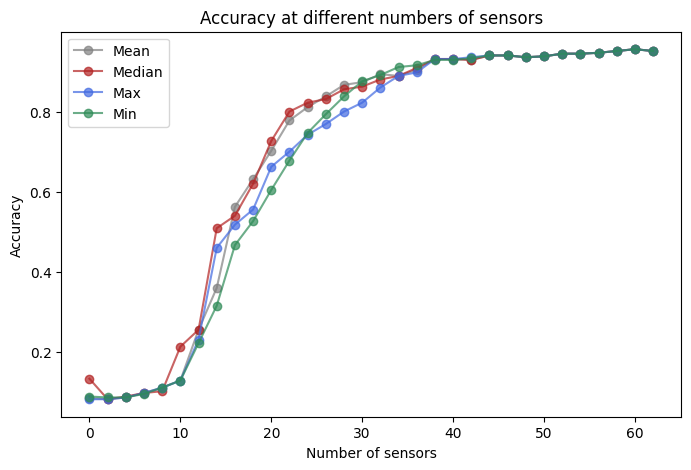

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
plot_kws = dict(alpha=0.7, marker="o", linestyle=None)

methods = (np.mean, np.median, np.max, np.min)
names = ('Mean', 'Median', 'Max', 'Min')
colors = ('gray', 'firebrick', 'royalblue', 'seagreen')

accuracy = {name: [] for name in names}
n_sensors_array = np.arange(0, 64, 2)

# Suppress warnings arising from no sensors being selected
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning)

    for n_sensors in n_sensors_array:
        for method, name in zip(methods, names):
            model.update_sensors(
                n_sensors=n_sensors, xy=(X_train, y_train), method=method, quiet=True
            )
            if model.n_sensors > 0:
                y_pred = model.predict(X_test[:, model.selected_sensors])
            else:
                y_pred = model.predict(X_test)
            accuracy[name].append(metrics.accuracy_score(y_test, y_pred))
        

for name, color in zip(names, colors):
    ax.plot(n_sensors_array, accuracy[name], color=color, label=name, **plot_kws)
    

ax.set(xlabel='Number of sensors', ylabel='Accuracy', title='Accuracy at different numbers of sensors')
ax.legend();

#### Thresholding
Another way to obtain different numbers of sensors is by applying a thresholding rule. We simply specify a threshold and use all sensors whose score exceeds it. Note that this entails that we won't be able to directly control the number of sensors that is chosen.

Let's see how the accuracy and number of sensors varies as we change the threshold.

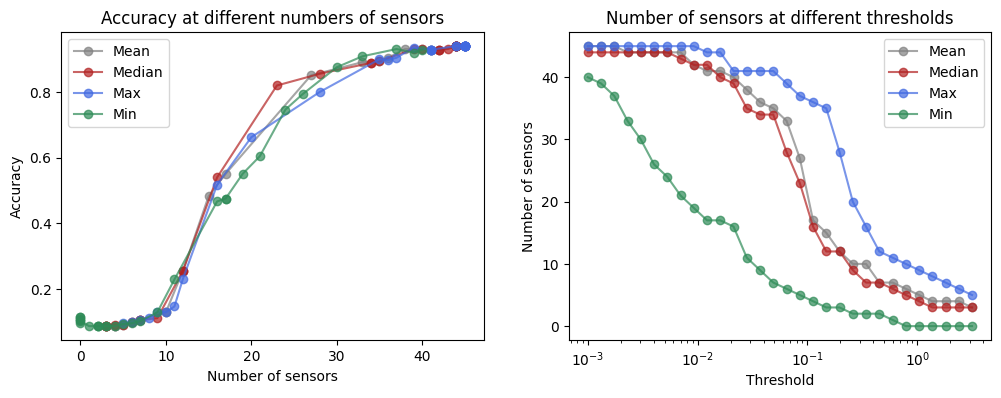

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

n_sensors = {name: [] for name in names}
accuracy = {name: [] for name in names}
thresholds = np.logspace(-3, 0.5, 30)

# Suppress warnings arising from no sensors being selected
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning)

    for thresh in thresholds:
        for method, name in zip(methods, names):
            model.update_sensors(threshold=thresh, xy=(X_train, y_train), method=method, quiet=True)
            if model.n_sensors > 0:
                y_pred = model.predict(X_test[:, model.selected_sensors])
            else:
                y_pred = model.predict(X_test)
            accuracy[name].append(metrics.accuracy_score(y_test, y_pred))
            n_sensors[name].append(len(model.selected_sensors))


for name, color in zip(names, colors):
    axs[0].plot(n_sensors[name], accuracy[name], color=color, label=name, **plot_kws)
    axs[1].plot(thresholds, n_sensors[name], color=color, label=name, **plot_kws)
    

axs[0].set(xlabel='Number of sensors', ylabel='Accuracy', title='Accuracy at different numbers of sensors')
axs[1].set(xlabel='Threshold', xscale='log', ylabel='Number of sensors', title='Number of sensors at different thresholds')
axs[0].legend()
axs[1].legend();

When the threshold is set high enough that no sensors are selected, the model will resort to predicting labels at random.

### Varying the L1 penalty
Another way to obtain different sets of sensors is to change the L1 regularization strength, `l1_penalty`, that's used when finding the coefficient matrix. This tweaks the underlying optimization problem, which can result in different slightly different sets of sensors being prioritized.

Let's see what the coefficient matrices look like for a few different choices of `l1_penalty`

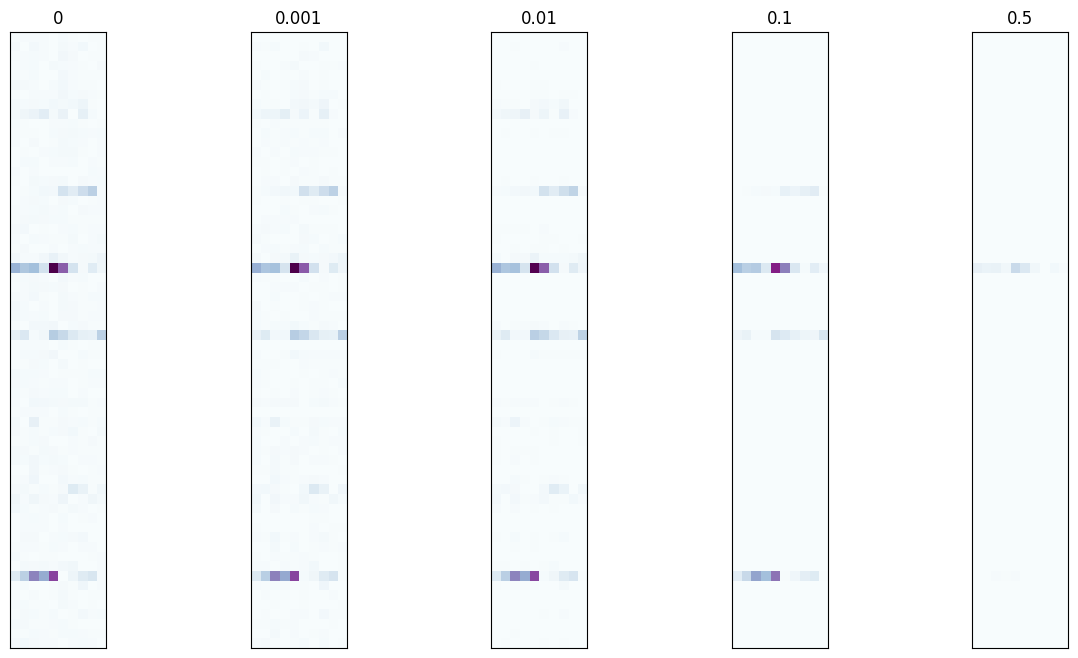

In [18]:
l1_penalties = [0, 0.001, 0.01, 0.1, 0.5]
fig, axs = plt.subplots(1, len(l1_penalties), figsize=(15, 8))

coefficient_matrices = [
    np.abs(
        SSPOC(l1_penalty=l1_penalty).fit(X_train, y_train, refit=False, quiet=True).sensor_coef_
    ) for l1_penalty in l1_penalties
]

vmax = max(np.max(s) for s in coefficient_matrices)
vmin = max(np.min(s) for s in coefficient_matrices)
plot_kws = dict(vmin=vmin, vmax=vmax, cmap="BuPu")

for l1_penalty, s, ax in zip(l1_penalties, coefficient_matrices, axs):
    ax.matshow(s, **plot_kws)
    ax.set(title=str(l1_penalty), xticks=[], yticks=[])

The dominant rows seem to be consistent, but there is some minor variation in the other rows.

Next we look at how the accuracy of the classifier changes as a function of the `l1_penalty` parameter. We also see how the number of selected sensors changes when we fix a threshold and vary `l1_penalty`.

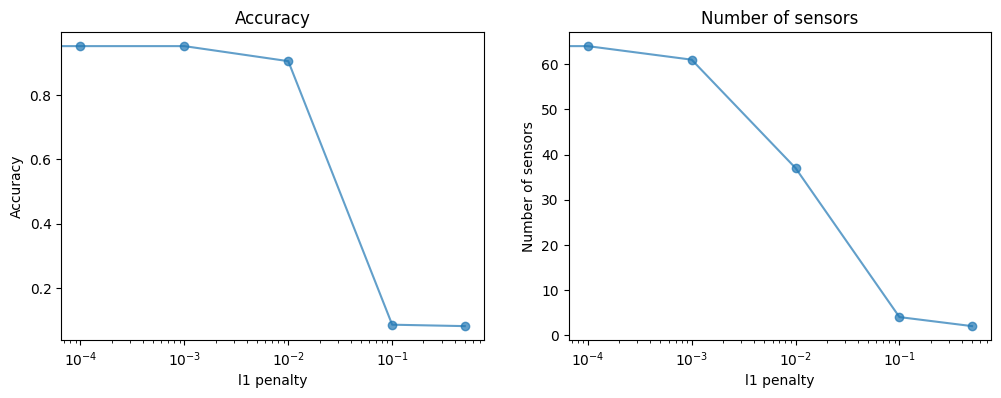

In [19]:
threshold = 0.1
l1_penalties = [0, 0.0001, 0.001, 0.01, 0.1, 0.5]

accuracy = []
n_sensors = []

for l1_penalty in l1_penalties:
    model = SSPOC(threshold=threshold, l1_penalty=l1_penalty).fit(X_train, y_train, quiet=True)
    if model.n_sensors > 0:
        y_pred = model.predict(X_test[:, model.selected_sensors])
    else:
        y_pred = model.predict(X_test)
    accuracy.append(metrics.accuracy_score(y_test, y_pred))
    n_sensors.append(model.n_sensors)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
plot_kws = dict(alpha=0.7, marker="o")
axs[0].plot(l1_penalties, accuracy, **plot_kws)
axs[0].set(xlabel="l1 penalty", ylabel="Accuracy", title="Accuracy", xscale="log")
axs[1].plot(l1_penalties, n_sensors, **plot_kws)
axs[1].set(xlabel="l1 penalty", ylabel="Number of sensors", title="Number of sensors", xscale="log");

## Other classifiers
`SSPOC` is compatible with other classifiers, namely *linear* classifiers. Any linear classifier implementing `fit` and `predict` methods and having a `coef_` attribute can be passed to a `SSPOC` instance.

Let's compare the performance of a few of Scikit-learn's popular linear classifiers. We'll allow each a budget of 20 sensors.

In [20]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier

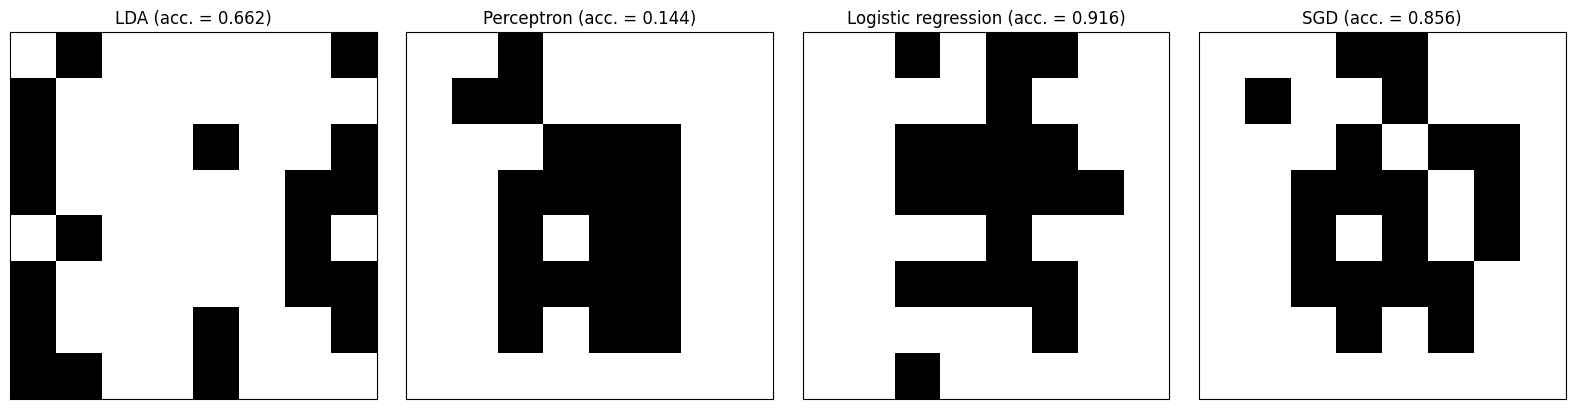

In [21]:
l1_penalty = 0.01
n_sensors = 20
classifiers = [
    ('LDA', LinearDiscriminantAnalysis()),
    ('Perceptron', Perceptron(penalty='elasticnet', alpha=0.1)),
    ('Logistic regression', LogisticRegression(C=10, max_iter=500, tol=1e-3)),
    ('SGD', SGDClassifier(max_iter=5000, loss='modified_huber', random_state=random_state)),
]

fig, axs = plt.subplots(1, 4, figsize=(16, 4))

for classifier, ax in zip(classifiers, axs):
    model = SSPOC(classifier=classifier[1], n_sensors=n_sensors, l1_penalty=l1_penalty)
    model.fit(X_train, y_train, quiet=True)

    # Check accuracy on training set
    y_pred = model.predict(X_test[:, model.selected_sensors])
    
    # Plot sensor locations
    plot_sensor_locations(model.selected_sensors, ax=ax)
    ax.set(
        title=f"{classifier[0]} (acc. = {metrics.accuracy_score(y_test, y_pred):.3f})"
    )

fig.tight_layout()

Though logistic regression fails to fully converge, it appears to make the most efficient use of its 20 sensors. It is interesting to note that LDA has so few sensors in common with the other classifiers.

## Other bases
In all the experiments thus far we've worked with the raw examples. What happens if we represent the images in different bases?

### Varying the number of sensors
We'll fix the number of basis modes at 32 and vary the number of sensors the models are allowed to use, then measure accuracy. We'll compare three bases: `Identity` (raw images), `SVD` (equivalent to PCA modes if the examples are centered), and `RandomProjection` (random projections of images).

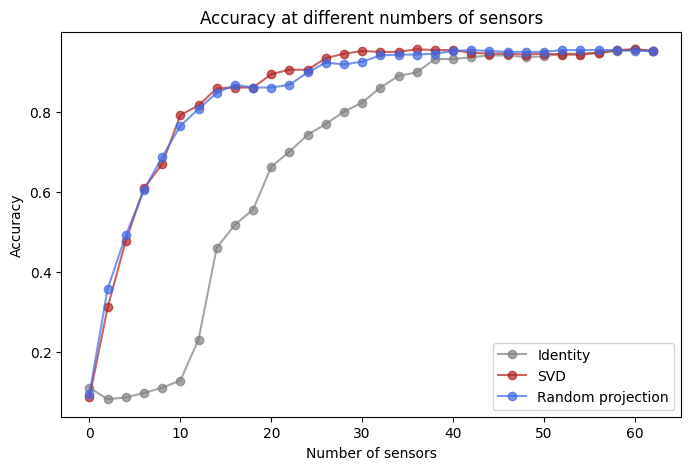

In [22]:
n_basis_modes = 32
l1_penalty = 0.01

names = ('Identity', 'SVD', 'Random projection')
bases = (
    ps.basis.Identity(n_basis_modes=n_basis_modes),
    ps.basis.SVD(n_basis_modes=n_basis_modes, random_state=random_state),
    ps.basis.RandomProjection(n_basis_modes=n_basis_modes, random_state=random_state),
)

accuracy = {name: [] for name in names}

# Suppress warnings arising from no sensors being selected
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning)

    for basis, name in zip(bases, names):
        model = SSPOC(basis=basis, l1_penalty=l1_penalty).fit(
            X_train, y_train, quiet=True, random_state=random_state
        )

        for n_sensors in n_sensors_array:
            model.update_sensors(n_sensors=n_sensors, xy=(X_train, y_train), quiet=True)
            if n_sensors == 0:
                accuracy[name].append(metrics.accuracy_score(y_test, model.predict(X_test)))
            else:
                accuracy[name].append(
                    metrics.accuracy_score(y_test, model.predict(X_test[:, model.selected_sensors]))
                )


fig, ax = plt.subplots(1, 1, figsize=(8, 5))
plot_kws = dict(alpha=0.7, marker="o", linestyle=None)

for name, color in zip(names, colors):
    ax.plot(n_sensors_array, accuracy[name], color=color, label=name, **plot_kws)

ax.set(xlabel='Number of sensors', ylabel='Accuracy', title='Accuracy at different numbers of sensors')
ax.legend();

The SVD and Random Projection bases exhibit much better performance for small sensor budgets.

### Varying the number of basis modes
Finally, we'll fix the number of sensors at 20 and vary the number of basis modes.

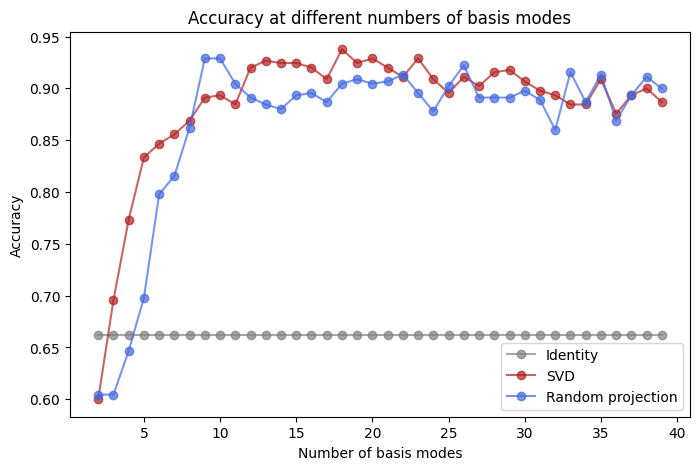

In [23]:
n_sensors = 20
n_basis_modes_array = np.arange(2, 40)

bases = (
    ps.basis.Identity(n_basis_modes=63),
    ps.basis.SVD(n_basis_modes=63, random_state=random_state),
    ps.basis.RandomProjection(n_basis_modes=63, random_state=random_state),
)

accuracy = {name: [] for name in names}

for basis, name in zip(bases, names):
    model = SSPOC(n_sensors=n_sensors, basis=basis, l1_penalty=l1_penalty).fit(
        X_train, y_train, quiet=True, random_state=random_state
    )
    
    for n_basis_modes in n_basis_modes_array:
        model.update_n_basis_modes(n_basis_modes=n_basis_modes, xy=(X_train, y_train), quiet=True)
        accuracy[name].append(metrics.accuracy_score(y_test, model.predict(X_test[:, model.selected_sensors])))


fig, ax = plt.subplots(1, 1, figsize=(8, 5))
plot_kws = dict(alpha=0.7, marker="o", linestyle=None)

for name, color in zip(names, colors):
    ax.plot(n_basis_modes_array, accuracy[name], color=color, label=name, **plot_kws)

ax.set(xlabel='Number of basis modes', ylabel='Accuracy', title='Accuracy at different numbers of basis modes')
ax.legend();

Only about 13 basis modes are needed for the SVD and Random Projection bases to perform well with 20 sensors.

The accuracy curve is flat for the Identity basis because the full identity matrix is automatically used as the basis; choosing a subset of the identity matrix as the basis would correspond to a restriction of the sensors that are considered when fitting the model.